In [1]:
# %matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import torch # not used

[WARN] no Optuna JSON found for 'AAPL' in 'optuna_results', using defaults
[WARN] no Optuna JSON found for 'AAPL' in 'optuna_results', using defaults


In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
from IPython.display import display, clear_output, update_display, HTML

import io
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)


Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


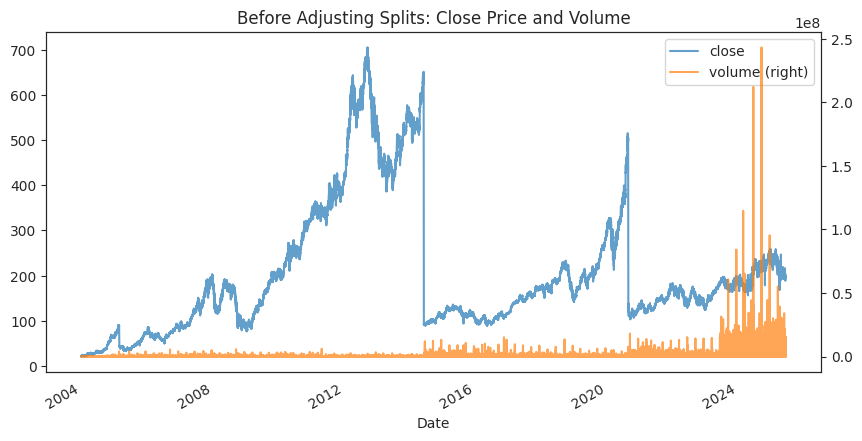

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


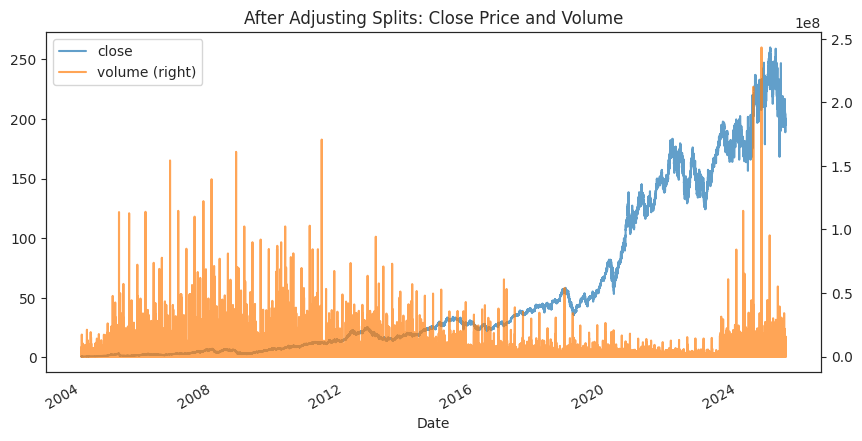

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 300
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder              = params.stocks_folder,
    ticker              = ticker,
    bidasktoclose_pct   = params.bidasktoclose_pct
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df              = df_raw,
    sess_premark    = params.sess_premark,
    sess_start      = params.sess_start,
    sess_end        = params.sess_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    pre_entry_decay, 
    short_penal_decay,
    trailing_stop_pct,
    buy_threshold,
    top_percentile,
    smoothing_window
) -> float:
    """
     Run full backtest → one Strategy Return ($) per calendar day.
     Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
     Print both, return avg_daily_pnl to Optuna.
    """

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal',
        col_action               = 'signal_action',

        # — Trade-ID parameters —
        min_prof_thr             = min_prof_thr,            # profit % threshold (profit_pc ≥ min_prof_thr),  
                                                             # e.g. 0.5 → require at least 0.5% gain  
        max_down_prop            = max_down_prop,           # max retracement **fraction** of that profit range before exit,  
                                                             # e.g. 0.2 → allow up to 20% retracement of your gain  
        gain_tightening_factor   = gain_tightening_factor,  # dimensionless factor that tightens max_down_prop per %-gain,  
                                                             # applied as base/(1 + factor×gain%)  
        merging_retracement_thr  = merging_retracement_thr, # intermediate retracement **ratio** to merge two trades,  
                                                             # e.g. 0.3 → allow up to a 30% pullback of trade1’s range  
        merging_time_gap_thr     = merging_time_gap_thr,    # time-gap **ratio** to merge two trades,  
                                                             # gap_sec/(duration1+duration2), dimensionless  
    
        # — Continuous-signal parameters —
        pre_entry_decay          = pre_entry_decay,         # per-minute decay rate on pre-entry signal (0–1),  
                                                             # lower≈0.01→slow fade, higher≈0.1→fast fade  
        short_penal_decay        = short_penal_decay,       # exponent penalty on short-trade durations,  
                                                             # >1 amplifies suppression of very short signals  
    
        # — Final-trigger parameters —
        trailing_stop_pct        = trailing_stop_pct,       # trailing-stop distance **percent**,  
                                                             # internally divided by 100,  
                                                             # e.g. 0.5 → 0.5% stop loss  
        buy_threshold            = buy_threshold,           # normalized signal threshold ∈[0,1] to enter trade,  
                                                             # e.g. 0.5 → require 50% signal  
        top_percentile           = top_percentile,           # percentile **percent** to cap signal at 1.0,  
                                                             # e.g. 1.0 → top 1% of raw signals become 1.0  
        smoothing_window         = smoothing_window
    )


    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    # — use all trading days for the daily-P&L average —
    num_days      = len(simulation)

    del simulation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")
    
    return avg_daily_pnl


In [5]:
def objective(trial):
    hyperpars = {
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.01, 0.05), # increasing min to 0.03, to avoid creating too many trades
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.6),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 3, 9),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.2, 0.6),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 2, 5),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.03, 0.09), # decreasing max to 0.05, to avoid too fast trading
        "short_penal_decay"       : trial.suggest_float("short_penal_decay", 3, 6),
        "trailing_stop_pct"       : trial.suggest_float("trailing_stop_pct", 0.03, 0.7), # increasing min to 0.03, to reproduce a realistic scenario of trailing stop loss
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.3, 0.6),
        "top_percentile"          : trial.suggest_float("top_percentile", 3, 5),
        "smoothing_window"        : trial.suggest_categorical("smoothing_window", [60])
    }

    print('----------------------------------------------------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[I 2025-09-03 20:06:51,895] A new study created in RDB with name: no-name-d8c53069-6c3e-43f4-bef5-3c29a94bc7e4


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:09<00:00, 21.62day/s]
[I 2025-09-03 20:11:32,104] Trial 0 finished with value: 0.22840388888888885 and parameters: {'min_prof_thr': 0.02346232025529548, 'max_down_prop': 0.15120437569837722, 'gain_tightening_factor': 7.8292236871733385, 'merging_retracement_thr': 0.4321254394175258, 'merging_time_gap_thr': 2.0910439724869683, 'pre_entry_decay': 0.0751487820833697, 'short_penal_decay': 4.386673658314948, 'trailing_stop_pct': 0.07886954124773735, 'buy_threshold': 0.4535390064198144, 'top_percentile': 3.5665318257997236, 'smoothing_window': 60}. Best is trial 0 with value: 0.22840388888888885.


→ Total return across 5400 trading days: $1233.38
→ Avg daily return (all days)          : $0.2284
→ Total trades                          : 9885
→ Avg return per trade                  : $0.1248



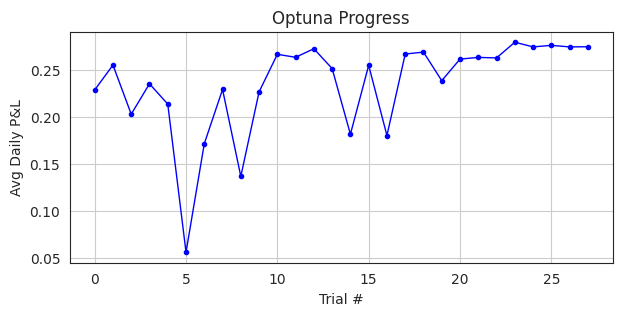

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:03<00:00, 22.17day/s]


→ Total return across 5400 trading days: $1376.37
→ Avg daily return (all days)          : $0.2549
→ Total trades                          : 6706
→ Avg return per trade                  : $0.2052



[I 2025-09-03 20:16:01,452] Trial 1 finished with value: 0.2548838888888889 and parameters: {'min_prof_thr': 0.04701699941280481, 'max_down_prop': 0.258857090034575, 'gain_tightening_factor': 5.034532014081095, 'merging_retracement_thr': 0.3766184370122312, 'merging_time_gap_thr': 4.128275200977007, 'pre_entry_decay': 0.03599185618794717, 'short_penal_decay': 3.257056913996104, 'trailing_stop_pct': 0.03960364958248034, 'buy_threshold': 0.5998664964356073, 'top_percentile': 4.453994203073918, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:48<00:00, 18.74day/s]
[I 2025-09-03 20:22:13,097] Trial 2 finished with value: 0.20265981481481482 and parameters: {'min_prof_thr': 0.04096150338529978, 'max_down_prop': 0.15555595189032792, 'gain_tightening_factor': 4.05250996414139, 'merging_retracement_thr': 0.433417303244739, 'merging_time_gap_thr': 2.4145909753743404, 'pre_entry_decay': 0.05762240124058031, 'short_penal_decay': 4.36041958498327, 'trailing_stop_pct': 0.5120373525372488, 'buy_threshold': 0.5170684598455393, 'top_percentile': 3.1293378541677654, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $1094.36
→ Avg daily return (all days)          : $0.2027
→ Total trades                          : 6824
→ Avg return per trade                  : $0.1604

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:00<00:00, 22.45day/s]
[I 2025-09-03 20:26:42,811] Trial 3 finished with value: 0.23494629629629635 and parameters: {'min_prof_thr': 0.03745334191236356, 'max_down_prop': 0.2413792949559658, 'gain_tightening_factor': 6.307086517419016, 'merging_retracement_thr': 0.4759740647306692, 'merging_time_gap_thr': 4.7760644605480795, 'pre_entry_decay': 0.05924468634169053, 'short_penal_decay': 5.347285987347964, 'trailing_stop_pct': 0.3202923114125956, 'buy_threshold': 0.5038460535388215, 'top_percentile': 4.408311371748954, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $1268.71
→ Avg daily return (all days)          : $0.2349
→ Total trades                          : 8551
→ Avg return per trade                  : $0.1484

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:27<00:00, 20.17day/s]
[I 2025-09-03 20:31:58,536] Trial 4 finished with value: 0.21340814814814815 and parameters: {'min_prof_thr': 0.017297606614988803, 'max_down_prop': 0.3415778867032937, 'gain_tightening_factor': 4.04507735032467, 'merging_retracement_thr': 0.23634193161094635, 'merging_time_gap_thr': 4.446961783804946, 'pre_entry_decay': 0.076348516715702, 'short_penal_decay': 5.107412925940766, 'trailing_stop_pct': 0.4109541442841518, 'buy_threshold': 0.4350779539181088, 'top_percentile': 3.6612569587910007, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $1152.40
→ Avg daily return (all days)          : $0.2134
→ Total trades                          : 8937
→ Avg return per trade                  : $0.1289

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:00<00:00, 29.96day/s]
[I 2025-09-03 20:35:37,022] Trial 5 finished with value: 0.055875925925925926 and parameters: {'min_prof_thr': 0.031158601707479007, 'max_down_prop': 0.520805592282728, 'gain_tightening_factor': 5.409388085551481, 'merging_retracement_thr': 0.5862296220005039, 'merging_time_gap_thr': 2.8603402658466517, 'pre_entry_decay': 0.08003112528055079, 'short_penal_decay': 4.0327647159622595, 'trailing_stop_pct': 0.691693081893387, 'buy_threshold': 0.3020624364115268, 'top_percentile': 3.642456462471048, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $301.73
→ Avg daily return (all days)          : $0.0559
→ Total trades                          : 9348
→ Avg return per trade                  : $0.0323

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:51<00:00, 31.44day/s]
[I 2025-09-03 20:39:00,745] Trial 6 finished with value: 0.17121592592592594 and parameters: {'min_prof_thr': 0.027018508698294294, 'max_down_prop': 0.17065009907559334, 'gain_tightening_factor': 6.227639006266166, 'merging_retracement_thr': 0.2537894180484306, 'merging_time_gap_thr': 4.71910512505924, 'pre_entry_decay': 0.0416822408708629, 'short_penal_decay': 4.636961292465097, 'trailing_stop_pct': 0.6484048325584016, 'buy_threshold': 0.3236286873290526, 'top_percentile': 3.5541346940019345, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $924.57
→ Avg daily return (all days)          : $0.1712
→ Total trades                          : 8553
→ Avg return per trade                  : $0.1081

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:59<00:00, 30.10day/s]
[I 2025-09-03 20:42:21,679] Trial 7 finished with value: 0.22893481481481479 and parameters: {'min_prof_thr': 0.028271706089908637, 'max_down_prop': 0.48364500677311684, 'gain_tightening_factor': 5.116663385784116, 'merging_retracement_thr': 0.593889123937857, 'merging_time_gap_thr': 3.8872049501605055, 'pre_entry_decay': 0.05480672586294874, 'short_penal_decay': 4.431573160683208, 'trailing_stop_pct': 0.13148608030632325, 'buy_threshold': 0.5661233710280265, 'top_percentile': 3.5540625372948145, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $1236.25
→ Avg daily return (all days)          : $0.2289
→ Total trades                          : 7124
→ Avg return per trade                  : $0.1735

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:05<00:00, 29.04day/s]
[I 2025-09-03 20:45:56,243] Trial 8 finished with value: 0.1365312962962963 and parameters: {'min_prof_thr': 0.04956573157245834, 'max_down_prop': 0.4758599756801839, 'gain_tightening_factor': 6.590976858087557, 'merging_retracement_thr': 0.3214831553216762, 'merging_time_gap_thr': 3.6941462913523786, 'pre_entry_decay': 0.07416220003565713, 'short_penal_decay': 5.5296786002456315, 'trailing_stop_pct': 0.49064027389678666, 'buy_threshold': 0.345760229942613, 'top_percentile': 4.937596069537652, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $737.27
→ Avg daily return (all days)          : $0.1365
→ Total trades                          : 10341
→ Avg return per trade                  : $0.0713

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:27<00:00, 26.06day/s]
[I 2025-09-03 20:49:54,212] Trial 9 finished with value: 0.22637074074074076 and parameters: {'min_prof_thr': 0.015325833234147681, 'max_down_prop': 0.1983707210047411, 'gain_tightening_factor': 5.450738368616885, 'merging_retracement_thr': 0.22993946123923098, 'merging_time_gap_thr': 4.554049500918788, 'pre_entry_decay': 0.03814269142356817, 'short_penal_decay': 3.264341626727684, 'trailing_stop_pct': 0.5760097159733367, 'buy_threshold': 0.4827137335843839, 'top_percentile': 3.17443416421169, 'smoothing_window': 60}. Best is trial 1 with value: 0.2548838888888889.


→ Total return across 5400 trading days: $1222.40
→ Avg daily return (all days)          : $0.2264
→ Total trades                          : 6574
→ Avg return per trade                  : $0.1859

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:14<00:00, 27.70day/s]
[I 2025-09-03 20:53:33,102] Trial 10 finished with value: 0.2662961111111111 and parameters: {'min_prof_thr': 0.04994915776906365, 'max_down_prop': 0.32609091997033385, 'gain_tightening_factor': 3.0882758304892035, 'merging_retracement_thr': 0.3461433824435649, 'merging_time_gap_thr': 3.067397174622567, 'pre_entry_decay': 0.030710940329694555, 'short_penal_decay': 3.032372485653463, 'trailing_stop_pct': 0.27364756216429054, 'buy_threshold': 0.564235344307191, 'top_percentile': 4.344165095721122, 'smoothing_window': 60}. Best is trial 10 with value: 0.2662961111111111.


→ Total return across 5400 trading days: $1438.00
→ Avg daily return (all days)          : $0.2663
→ Total trades                          : 6719
→ Avg return per trade                  : $0.2140

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:16<00:00, 21.04day/s]
[I 2025-09-03 20:58:14,731] Trial 11 finished with value: 0.2631177777777778 and parameters: {'min_prof_thr': 0.04911963000784975, 'max_down_prop': 0.3193275924671412, 'gain_tightening_factor': 3.472190941886102, 'merging_retracement_thr': 0.33838543487803313, 'merging_time_gap_thr': 3.1562740658895443, 'pre_entry_decay': 0.03022882032640167, 'short_penal_decay': 3.064289699438802, 'trailing_stop_pct': 0.22785097055228987, 'buy_threshold': 0.5871698062674418, 'top_percentile': 4.362735739872123, 'smoothing_window': 60}. Best is trial 10 with value: 0.2662961111111111.


→ Total return across 5400 trading days: $1420.84
→ Avg daily return (all days)          : $0.2631
→ Total trades                          : 6423
→ Avg return per trade                  : $0.2212

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:27<00:00, 20.22day/s]
[I 2025-09-03 21:03:15,135] Trial 12 finished with value: 0.27220444444444447 and parameters: {'min_prof_thr': 0.042618462917078936, 'max_down_prop': 0.3731669543000845, 'gain_tightening_factor': 3.020390698820545, 'merging_retracement_thr': 0.3277083718947219, 'merging_time_gap_thr': 3.1777045514411153, 'pre_entry_decay': 0.03052381591791358, 'short_penal_decay': 3.078099243553356, 'trailing_stop_pct': 0.23927650082976176, 'buy_threshold': 0.5564664862218826, 'top_percentile': 4.296718890921696, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1469.90
→ Avg daily return (all days)          : $0.2722
→ Total trades                          : 6826
→ Avg return per trade                  : $0.2153

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:32<00:00, 19.85day/s]
[I 2025-09-03 21:08:24,032] Trial 13 finished with value: 0.2511487037037037 and parameters: {'min_prof_thr': 0.04089638701826908, 'max_down_prop': 0.4030890841153195, 'gain_tightening_factor': 3.099452948377778, 'merging_retracement_thr': 0.3297063673571975, 'merging_time_gap_thr': 3.181522588951532, 'pre_entry_decay': 0.047224862709517944, 'short_penal_decay': 3.646547244256848, 'trailing_stop_pct': 0.2675983981781679, 'buy_threshold': 0.5383389886431585, 'top_percentile': 4.009191057589383, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1356.20
→ Avg daily return (all days)          : $0.2511
→ Total trades                          : 7529
→ Avg return per trade                  : $0.1801

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:15<00:00, 21.11day/s]
[I 2025-09-03 21:13:17,230] Trial 14 finished with value: 0.18130203703703704 and parameters: {'min_prof_thr': 0.0428123677531071, 'max_down_prop': 0.4071831932490271, 'gain_tightening_factor': 4.106914722498888, 'merging_retracement_thr': 0.2916289957111738, 'merging_time_gap_thr': 2.717449952322861, 'pre_entry_decay': 0.08914541831617918, 'short_penal_decay': 3.6053158083665346, 'trailing_stop_pct': 0.18524745667820905, 'buy_threshold': 0.4110866325677808, 'top_percentile': 4.702549431444952, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $979.03
→ Avg daily return (all days)          : $0.1813
→ Total trades                          : 11791
→ Avg return per trade                  : $0.0830

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:22<00:00, 20.56day/s]
[I 2025-09-03 21:18:11,748] Trial 15 finished with value: 0.25457129629629627 and parameters: {'min_prof_thr': 0.03557382798452202, 'max_down_prop': 0.5846703172513766, 'gain_tightening_factor': 3.0129204014296604, 'merging_retracement_thr': 0.5035353408243621, 'merging_time_gap_thr': 3.4057891312015727, 'pre_entry_decay': 0.03143638699181743, 'short_penal_decay': 3.7109808546043244, 'trailing_stop_pct': 0.34823016038815463, 'buy_threshold': 0.547531980424167, 'top_percentile': 4.118624548758535, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1374.68
→ Avg daily return (all days)          : $0.2546
→ Total trades                          : 6832
→ Avg return per trade                  : $0.2012

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.84day/s]
[I 2025-09-03 21:23:04,544] Trial 16 finished with value: 0.1799398148148148 and parameters: {'min_prof_thr': 0.04401734868841529, 'max_down_prop': 0.28355739931671375, 'gain_tightening_factor': 8.504948526809535, 'merging_retracement_thr': 0.38189760135583234, 'merging_time_gap_thr': 2.7322965392441296, 'pre_entry_decay': 0.049552585232303964, 'short_penal_decay': 3.0996904317859304, 'trailing_stop_pct': 0.41215301860559295, 'buy_threshold': 0.3863976217499093, 'top_percentile': 4.245887371488573, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $971.67
→ Avg daily return (all days)          : $0.1799
→ Total trades                          : 9841
→ Avg return per trade                  : $0.0987

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:25<00:00, 20.30day/s]
[I 2025-09-03 21:28:04,524] Trial 17 finished with value: 0.2666001851851852 and parameters: {'min_prof_thr': 0.03349716397846532, 'max_down_prop': 0.38810225581225904, 'gain_tightening_factor': 4.32617587135802, 'merging_retracement_thr': 0.28623918901347734, 'merging_time_gap_thr': 3.323495608620376, 'pre_entry_decay': 0.06575118492291113, 'short_penal_decay': 5.851858825395615, 'trailing_stop_pct': 0.16397155049573114, 'buy_threshold': 0.4737843419118298, 'top_percentile': 4.657107790046888, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1439.64
→ Avg daily return (all days)          : $0.2666
→ Total trades                          : 9479
→ Avg return per trade                  : $0.1519

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:22<00:00, 20.59day/s]
[I 2025-09-03 21:33:00,330] Trial 18 finished with value: 0.26864518518518515 and parameters: {'min_prof_thr': 0.034291551543984534, 'max_down_prop': 0.40499237460487825, 'gain_tightening_factor': 4.477935960236686, 'merging_retracement_thr': 0.28167037499400743, 'merging_time_gap_thr': 3.504625492305717, 'pre_entry_decay': 0.06568594299173966, 'short_penal_decay': 5.953161430954712, 'trailing_stop_pct': 0.15131034620655662, 'buy_threshold': 0.47229499696808286, 'top_percentile': 4.680873629437716, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1450.68
→ Avg daily return (all days)          : $0.2686
→ Total trades                          : 9554
→ Avg return per trade                  : $0.1518

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:19<00:00, 20.81day/s]
[I 2025-09-03 21:37:56,174] Trial 19 finished with value: 0.23828296296296297 and parameters: {'min_prof_thr': 0.037743064272077124, 'max_down_prop': 0.10284826879748549, 'gain_tightening_factor': 4.5225776808112155, 'merging_retracement_thr': 0.2780965620157345, 'merging_time_gap_thr': 3.6879195194432177, 'pre_entry_decay': 0.06673892274699801, 'short_penal_decay': 4.961639235592602, 'trailing_stop_pct': 0.11462180399287636, 'buy_threshold': 0.3832795465909359, 'top_percentile': 4.951058649412973, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1286.73
→ Avg daily return (all days)          : $0.2383
→ Total trades                          : 11847
→ Avg return per trade                  : $0.1086

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:21<00:00, 20.63day/s]
[I 2025-09-03 21:42:51,027] Trial 20 finished with value: 0.2611983333333333 and parameters: {'min_prof_thr': 0.02517481103907716, 'max_down_prop': 0.46253732004193787, 'gain_tightening_factor': 6.8766638918394545, 'merging_retracement_thr': 0.21181781401292935, 'merging_time_gap_thr': 4.05773737860671, 'pre_entry_decay': 0.06452364460123404, 'short_penal_decay': 5.963712229899819, 'trailing_stop_pct': 0.23173221281879824, 'buy_threshold': 0.5087086499633144, 'top_percentile': 4.645588974855805, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1410.47
→ Avg daily return (all days)          : $0.2612
→ Total trades                          : 8647
→ Avg return per trade                  : $0.1631

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:21<00:00, 20.61day/s]
[I 2025-09-03 21:47:45,763] Trial 21 finished with value: 0.2630074074074074 and parameters: {'min_prof_thr': 0.03327586699087723, 'max_down_prop': 0.39686721753437987, 'gain_tightening_factor': 4.707055637475118, 'merging_retracement_thr': 0.28973741484048293, 'merging_time_gap_thr': 3.5663454830313306, 'pre_entry_decay': 0.06595591076212932, 'short_penal_decay': 5.996022986188919, 'trailing_stop_pct': 0.18293637592593973, 'buy_threshold': 0.46336744962759924, 'top_percentile': 4.668942002975324, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1420.24
→ Avg daily return (all days)          : $0.2630
→ Total trades                          : 9675
→ Avg return per trade                  : $0.1468

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:18<00:00, 20.85day/s]
[I 2025-09-03 21:52:42,062] Trial 22 finished with value: 0.2624514814814815 and parameters: {'min_prof_thr': 0.021122518359506893, 'max_down_prop': 0.43313968202426595, 'gain_tightening_factor': 3.849522245981796, 'merging_retracement_thr': 0.27344089716347736, 'merging_time_gap_thr': 3.3853041775673627, 'pre_entry_decay': 0.06977822588529581, 'short_penal_decay': 5.6686802577141595, 'trailing_stop_pct': 0.15706220958244288, 'buy_threshold': 0.4746006021317305, 'top_percentile': 4.5564129397870685, 'smoothing_window': 60}. Best is trial 12 with value: 0.27220444444444447.


→ Total return across 5400 trading days: $1417.24
→ Avg daily return (all days)          : $0.2625
→ Total trades                          : 9642
→ Avg return per trade                  : $0.1470

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:24<00:00, 20.40day/s]
[I 2025-09-03 21:57:40,738] Trial 23 finished with value: 0.27914425925925923 and parameters: {'min_prof_thr': 0.03256983955883835, 'max_down_prop': 0.37114780663207564, 'gain_tightening_factor': 4.511939574085151, 'merging_retracement_thr': 0.20134257515959378, 'merging_time_gap_thr': 2.9623626157486562, 'pre_entry_decay': 0.049465395929729275, 'short_penal_decay': 5.728205239290818, 'trailing_stop_pct': 0.03500074873614539, 'buy_threshold': 0.4324393359670636, 'top_percentile': 4.746756950775603, 'smoothing_window': 60}. Best is trial 23 with value: 0.27914425925925923.


→ Total return across 5400 trading days: $1507.38
→ Avg daily return (all days)          : $0.2791
→ Total trades                          : 9959
→ Avg return per trade                  : $0.1514

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:17<00:00, 20.95day/s]
[I 2025-09-03 22:02:32,836] Trial 24 finished with value: 0.27417037037037034 and parameters: {'min_prof_thr': 0.031807570991056806, 'max_down_prop': 0.3731078973471119, 'gain_tightening_factor': 5.759102970927692, 'merging_retracement_thr': 0.20244116924854566, 'merging_time_gap_thr': 2.4584099504294454, 'pre_entry_decay': 0.049985879849891106, 'short_penal_decay': 5.302788727400369, 'trailing_stop_pct': 0.05158469977599395, 'buy_threshold': 0.42648076115031325, 'top_percentile': 4.8246089181493055, 'smoothing_window': 60}. Best is trial 23 with value: 0.27914425925925923.


→ Total return across 5400 trading days: $1480.52
→ Avg daily return (all days)          : $0.2742
→ Total trades                          : 10217
→ Avg return per trade                  : $0.1449

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:23<00:00, 20.47day/s]
[I 2025-09-03 22:07:34,693] Trial 25 finished with value: 0.2757962962962963 and parameters: {'min_prof_thr': 0.01109297210581665, 'max_down_prop': 0.35990021360139013, 'gain_tightening_factor': 5.849796892763667, 'merging_retracement_thr': 0.20498592948345307, 'merging_time_gap_thr': 2.472709835196977, 'pre_entry_decay': 0.04554001966093307, 'short_penal_decay': 4.90724401984875, 'trailing_stop_pct': 0.03745356357878985, 'buy_threshold': 0.4216659269572771, 'top_percentile': 4.8793299721608845, 'smoothing_window': 60}. Best is trial 23 with value: 0.27914425925925923.


→ Total return across 5400 trading days: $1489.30
→ Avg daily return (all days)          : $0.2758
→ Total trades                          : 10245
→ Avg return per trade                  : $0.1454

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [04:27<00:00, 20.21day/s]
[I 2025-09-03 22:12:44,977] Trial 26 finished with value: 0.2741724074074074 and parameters: {'min_prof_thr': 0.010929887185998863, 'max_down_prop': 0.28100321555290214, 'gain_tightening_factor': 5.785284018857174, 'merging_retracement_thr': 0.21090361430253018, 'merging_time_gap_thr': 2.368837905982847, 'pre_entry_decay': 0.04834908655873991, 'short_penal_decay': 4.9309763943686375, 'trailing_stop_pct': 0.043709711826329, 'buy_threshold': 0.4261097129094054, 'top_percentile': 4.850562071371026, 'smoothing_window': 60}. Best is trial 23 with value: 0.27914425925925923.


→ Total return across 5400 trading days: $1480.53
→ Avg daily return (all days)          : $0.2742
→ Total trades                          : 10131
→ Avg return per trade                  : $0.1461

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [03:54<00:00, 23.03day/s]
[I 2025-09-03 22:17:22,196] Trial 27 finished with value: 0.2743201851851852 and parameters: {'min_prof_thr': 0.010819364031445816, 'max_down_prop': 0.28355279255992605, 'gain_tightening_factor': 7.2168111619583435, 'merging_retracement_thr': 0.20340220597298403, 'merging_time_gap_thr': 2.039262065432917, 'pre_entry_decay': 0.04308490702043046, 'short_penal_decay': 4.7352945888081655, 'trailing_stop_pct': 0.09628401752342439, 'buy_threshold': 0.39014998471732054, 'top_percentile': 4.999466142858678, 'smoothing_window': 60}. Best is trial 23 with value: 0.27914425925925923.


→ Total return across 5400 trading days: $1481.33
→ Avg daily return (all days)          : $0.2743
→ Total trades                          : 10587
→ Avg return per trade                  : $0.1399

----------------------------------------------------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days:  17%|█▋        | 925/5400 [00:34<03:07, 23.86day/s]

In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback, plots.save_best_trial_callback],
    gc_after_trial=True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

file_name  = f"{ticker}_all.json"
file_path  = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
